## The Neural Network

In this notebook and in `models.py`:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs well

Results: When applied to test image data, the model should produce keypoints that closely match the true keypoints of each face.

## CNN Architecture

In [ ]:
# load the data from the web and unzip it
import os
import requests
import zipfile

# Create a folder 'data/' in the current directory
folder_name = 'data'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

# URL of the file to be downloaded
url = "https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip"
file_name = 'train-test-data.zip'

# Download the content into the 'data/' folder
response = requests.get(url)
with open(file_name, 'wb') as file:
    file.write(response.content)

downloaded_file_path = os.path.abspath(file_name)
print(f"File downloaded to {downloaded_file_path}")
print(f"File name: {file_name}")


# Unzip the file
with zipfile.ZipFile(file_name, 'r') as zip_ref:
    zip_ref.extractall(folder_name)

print(f"Files extracted to {os.path.abspath(folder_name)}")

In [1]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np


# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [ ]:
## Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F

# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# instantiate it here and print its structure
from models import Net

# Instantiate the network and move it to the device (GPU or CPU)
net = Net()
net.to(device)
print(net)

Using device: cuda
Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=25600, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=136, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


## Transform the dataset 

To prepare for training, we create a transformed dataset of images and keypoints.

These transformations have been defined in `data_load.py`

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor

# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale(250),
                                     RandomCrop(224),
                                     Normalize(),
                                     ToTensor()])

# testing that we've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [4]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='/workspace/data/training_frames_keypoints.csv',
                                             root_dir='/workspace/data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


## Batching and loading data

In [5]:
# load training data in batches
batch_size = 10

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)


## Before training

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, to see how the model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [ ]:
# load in the test data, using the dataset class
# AND apply the data_transform

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='/workspace/data/test_frames_keypoints.csv',
                                             root_dir='/workspace/data/test/',
                                             transform=data_transform)



In [7]:
# load test data in batches
batch_size = 10

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)

## Apply the model on a test sample

This function tests how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [8]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image'].to(device)
        key_pts = sample['keypoints'].to(device)

        # convert images to FloatTensors
        images = images.type(torch.cuda.FloatTensor)

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

In [9]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points

In [10]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

`visualize_output` takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

In [11]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)
        
        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.cpu()
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.cpu()
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i].cpu().numpy()
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
#visualize_output(test_images, test_outputs, gt_pts)

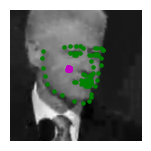

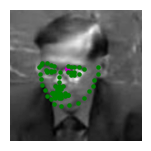

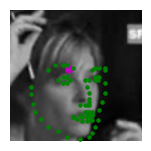

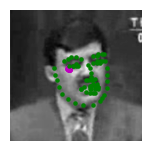

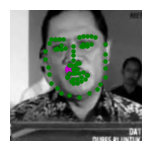

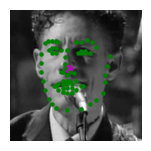

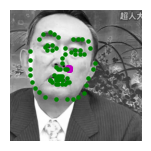

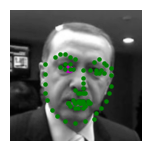

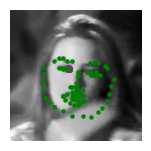

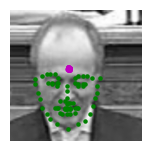

In [12]:
visualize_output(test_images, test_outputs, gt_pts)

## Training

In [ ]:
## Define the loss and optimization
import torch.optim as optim

criterion = nn.SmoothL1Loss()

optimizer = optim.Adam(net.parameters(), lr=0.001)


## Training and Initial Observation

In [ ]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image'].to(device)
            key_pts = data['keypoints'].to(device)

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.cuda.FloatTensor)
            images = images.type(torch.cuda.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/10))
                running_loss = 0.0

    print('Finished Training')


In [ ]:
# train the network
n_epochs = 5 # start small

train_net(n_epochs)

Epoch: 1, Batch: 10, Avg. Loss: 0.22737660109996796
Epoch: 1, Batch: 20, Avg. Loss: 0.12036757990717888
Epoch: 1, Batch: 30, Avg. Loss: 0.10746155679225922
Epoch: 1, Batch: 40, Avg. Loss: 0.08910309448838234
Epoch: 1, Batch: 50, Avg. Loss: 0.08424021862447262
Epoch: 1, Batch: 60, Avg. Loss: 0.10640612617135048
Epoch: 1, Batch: 70, Avg. Loss: 0.08436641730368137
Epoch: 1, Batch: 80, Avg. Loss: 0.11134577840566635
Epoch: 1, Batch: 90, Avg. Loss: 0.0893747165799141
Epoch: 1, Batch: 100, Avg. Loss: 0.07217949442565441
Epoch: 1, Batch: 110, Avg. Loss: 0.10140336751937866
Epoch: 1, Batch: 120, Avg. Loss: 0.11491416096687317
Epoch: 1, Batch: 130, Avg. Loss: 0.09055295549333095
Epoch: 1, Batch: 140, Avg. Loss: 0.09268397130072117
Epoch: 1, Batch: 150, Avg. Loss: 0.09612239971756935
Epoch: 1, Batch: 160, Avg. Loss: 0.09068636447191239
Epoch: 1, Batch: 170, Avg. Loss: 0.09587923064827919
Epoch: 1, Batch: 180, Avg. Loss: 0.0917111612856388
Epoch: 1, Batch: 190, Avg. Loss: 0.08219153955578803
Epoc

Epoch: 5, Batch: 210, Avg. Loss: 0.08987226746976376
Epoch: 5, Batch: 220, Avg. Loss: 0.08676981888711452
Epoch: 5, Batch: 230, Avg. Loss: 0.09859514348208905
Epoch: 5, Batch: 240, Avg. Loss: 0.07803673073649406
Epoch: 5, Batch: 250, Avg. Loss: 0.10208542421460151
Epoch: 5, Batch: 260, Avg. Loss: 0.1010056532919407
Epoch: 5, Batch: 270, Avg. Loss: 0.087475873157382
Epoch: 5, Batch: 280, Avg. Loss: 0.10698111057281494
Epoch: 5, Batch: 290, Avg. Loss: 0.10791175924241543
Epoch: 5, Batch: 300, Avg. Loss: 0.10405266880989075
Epoch: 5, Batch: 310, Avg. Loss: 0.09399397410452366
Epoch: 5, Batch: 320, Avg. Loss: 0.09731587283313274
Epoch: 5, Batch: 330, Avg. Loss: 0.08545089438557625
Epoch: 5, Batch: 340, Avg. Loss: 0.09042683951556682
Finished Training


## Test data

See how the model performs on previously unseen, test data.

In [16]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


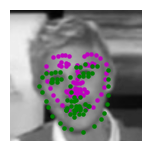

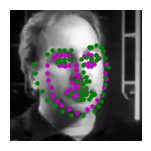

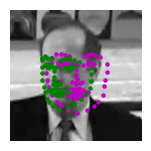

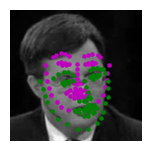

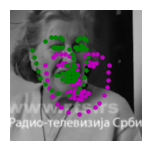

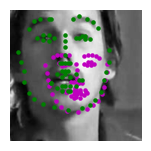

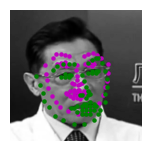

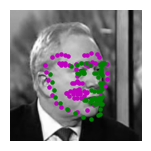

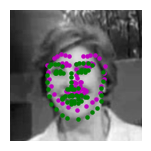

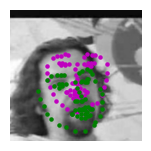

In [ ]:
## visualize test output
visualize_output(test_images, test_outputs, gt_pts)


### Saving the model

In [ ]:
## change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'keypoints_model_1.pt'

# after training, save the model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

### Choosing the optimization and loss functions


#### SmoothL1Loss loss function combines the benefits of MSE (for small errors) and MAE (for large errors), making it more robust. For optimization, I used Adam because it adaptively adjusts learning rates for each parameter, converges faster than basic SGD

### Deciding the Network Architecture

#### I started with a simple architecture featuring one convolutional layer followed by pooling and a couple of fully connected layers. To improve feature extraction, I expanded it to four convolutional layers with increasing filter counts (32, 64, 128, 256) to capture hierarchical features from low-level edges to high-level facial structures. I added maxpooling after each conv layer to reduce spatial dimensions and computational load. To avoid overfitting, I incorporated dropout layers (p=0.25) after the fully connected layers.

### The Hyperparameters

#### I started with a small number of epochs (1-5) to quickly assess if the loss was decreasing and to debug the model. Once the architecture was stable it can be increased. Batch size was set to 10 initially for more frequent weight updates and to fit within memory constraints, but it could be increased to 32 for faster training (hardware permitting)

## Feature Visualization

[[-0.08759799 -0.08311141  0.08542629 -0.1279397  -0.05518467]
 [ 0.12561207  0.09786079 -0.18336086  0.08452853  0.16740724]
 [ 0.09163033  0.07757893  0.04995273 -0.03191058  0.15885682]
 [-0.13758175 -0.13500232 -0.06715726 -0.06853189  0.0944365 ]
 [ 0.11425947 -0.1756043   0.00262888  0.14128396 -0.06561027]]
(5, 5)


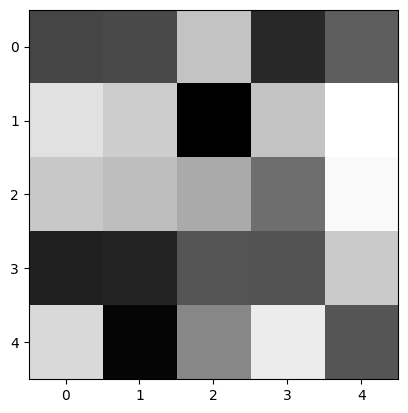

In [ ]:
# Get the weights in the first conv layer, "conv1"
weights1 = net.conv1.weight.data.cpu()

w = weights1.numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

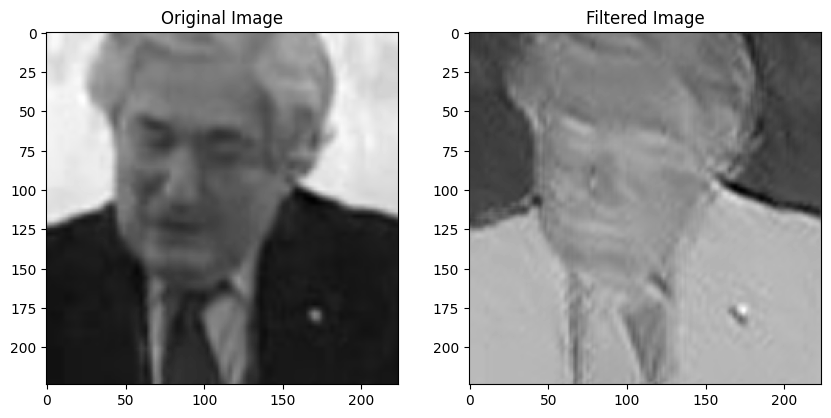

In [ ]:
# Using cv's filter2D function
import cv2

sample = test_dataset[0]
image = sample['image'].numpy().squeeze()  # Grayscale, remove channel dim

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')

# Apply a filter
filter_index = 5
filter_weights = w[filter_index][0]  # Assuming w from earlier cell

filtered_image = cv2.filter2D(image, -1, filter_weights)

plt.subplot(1,2,2)
plt.imshow(filtered_image, cmap='gray')
plt.title('Filtered Image')
plt.show()

#### The chosen filter (from the first conv layer) seems to act as an edge detector, particularly emphasizing horizontal and diagonal edges in the facial features (e.g., jawline, eyebrows). It highlights boundaries and textures while suppressing uniform areas.

---
## Moving on!
In the last notebook, a complete pipeline which combines a face detector with the saved model to create a facial keypoint detection system that can predict the keypoints on any face in an image!